# Import libs

Código adaptado de:

https://github.com/DmitryUlyanov/deep-image-prior/

https://github.com/csdwren/SelfDeblur


In [1]:
from __future__ import print_function
import argparse
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import join
import re
%matplotlib inline

from PIL import Image
import PIL

from numpy.random import normal
from numpy.linalg import svd
from math import sqrt, exp
from skimage.metrics import structural_similarity
from skimage.restoration import denoise_tv_bregman
import joblib
from sklearn import mixture
import cv2

import torch
import torch.nn as nn
import torch.nn.init
import torch.nn.functional as F
import torch.optim
import torchvision

torch.backends.cudnn.enabled = True #False #
torch.backends.cudnn.benchmark = True #False #
dtype = torch.cuda.FloatTensor #torch.FloatTensor #
mse = torch.nn.MSELoss().type(dtype)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utils

Funções e classes utilizadas ao longo do código. 

## utils/common_utils

In [3]:
def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d, 
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2), 
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped

def get_params(opt_over, net, net_input, blur=None):
    '''Returns parameters that we want to optimize over.
    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='blur':
            assert blur is not None
            params = [x for x in blur.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params

def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid
    
    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size of the plt.figure 
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"
    
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)
    
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    
    plt.show()
    
    return grid

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img

def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size. 
    Args: 
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np

def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  np_to_torch(meshgrid)
    else:
        assert False
        
    return net_input

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / np.max(ar)

def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.
    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.
    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def optimize(optimizer_type, parameters, closure, LR, num_iter,scheduler_param=None):
    """Runs optimization loop.
    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        if scheduler_param is not None:
          scheduler = MultiStepLR(optimizer, milestones=scheduler_param['milestones'], gamma=scheduler_param['gamma'])
        
        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
            
            if(scheduler_param is not None):
              scheduler.step()
    else:
        assert False

## utils/sr_utils

In [4]:
def put_in_center(img_np, target_size):
    img_out = np.zeros([3, target_size[0], target_size[1]])
    
    bbox = [
            int((target_size[0] - img_np.shape[1]) / 2),
            int((target_size[1] - img_np.shape[2]) / 2),
            int((target_size[0] + img_np.shape[1]) / 2),
            int((target_size[1] + img_np.shape[2]) / 2),
    ]
    
    img_out[:, bbox[0]:bbox[2], bbox[1]:bbox[3]] = img_np
    
    return img_out

def load_img(fname, width, enforse_div32=None):
    '''Loads an image, resizes it, center crops and downscales.
    Args: 
        fname: path to the image
        width: desired width size
        enforse_div32: if 'CROP' center crops an image, so that its dimensions are divisible by 32.
    '''
    _,img_np = get_image(fname, -1)
    img_pil = np_to_pil(img_np)

    factor = width / img_pil.size[0] 

    LR_size = [
               width, 
               np.round(img_pil.size[1]*factor).astype(int)
    ]

    img_LR_pil = img_pil.resize(LR_size, Image.ANTIALIAS)
    img_LR_np = pil_to_np(img_LR_pil)
    
    if enforse_div32 == 'EXTEND':
        new_size = [32 - img_LR_np.shape[1] % 32, 
                    32 - img_LR_np.shape[2] % 32]
        
        new_size = (np.array(new_size)!=32)*new_size

        bbox = (
                (0,0),
                (0,new_size[0]),
                (0,new_size[1])
                )

        img_LR_np = np.pad(img_LR_np,bbox,mode='reflect')

    return img_LR_np

def tv_loss(x, beta = 0.5):
    '''Calculates TV loss for an image `x`.
        
    Args:
        x: image, torch.Variable of torch.Tensor
        beta: See https://arxiv.org/abs/1412.0035 (fig. 2) to see effect of `beta` 
    '''
    dh = torch.pow(x[:,:,:,1:] - x[:,:,:,:-1], 2)
    dw = torch.pow(x[:,:,1:,:] - x[:,:,:-1,:], 2)
    
    return torch.sum(torch.pow(dh[:, :, :-1] + dw[:, :, :, :-1], beta))

## models/common

In [5]:
def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
    
torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]        

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)


class GenNoise(nn.Module):
    def __init__(self, dim2):
        super(GenNoise, self).__init__()
        self.dim2 = dim2

    def forward(self, input):
        a = list(input.size())
        a[1] = self.dim2
        # print (input.data.type())

        b = torch.zeros(a).type_as(input.data)
        b.normal_()

        x = torch.autograd.Variable(b)

        return x


class Swish(nn.Module):
    """
        https://arxiv.org/abs/1710.05941
        The hype was so huge that I could not help but try it
    """
    def __init__(self):
        super(Swish, self).__init__()
        self.s = nn.Sigmoid()

    def forward(self, x):
        return x * self.s(x)


def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'Swish':
            return Swish()
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()


def bn(num_features):
    return nn.BatchNorm2d(num_features)


def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None
    if stride != 1 and downsample_mode != 'stride':

        if downsample_mode == 'avg':
            downsampler = nn.AvgPool2d(stride, stride)
        elif downsample_mode == 'max':
            downsampler = nn.MaxPool2d(stride, stride)
        elif downsample_mode  in ['lanczos2', 'lanczos3']:
            downsampler = Downsampler(n_planes=out_f, factor=stride, kernel_type=downsample_mode, phase=0.5, preserve_size=True)
        else:
            assert False

        stride = 1

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)


    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)

## models/skip

In [6]:
def skip(
        num_input_channels=2, num_output_channels=3, 
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4], 
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True, 
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU', 
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.
    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')
    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down) 

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales
    
    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1 

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential()
        skip = nn.Sequential()

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)
        
        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))
            
        # skip.add(Concat(2, GenNoise(nums_noise[i]), skip_part))

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model

## models/init

In [7]:
def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'ResNet':
        # TODO
        net = ResNet(input_depth, 3, 10, 16, 1, nn.BatchNorm2d, False)
    elif NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11, 
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)

    elif NET_TYPE == 'texture_nets':
        net = get_texture_nets(inp=input_depth, ratios = [32, 16, 8, 4, 2, 1], fill_noise=False,pad=pad)

    elif NET_TYPE =='UNet':
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=4, more_layers=0, concat_x=False,
                   upsample_mode=upsample_mode, pad=pad, norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True)
    elif NET_TYPE == 'identity':
        assert input_depth == 3
        net = nn.Sequential()
    else:
        assert False

    return net

## Blur

In [8]:
class Blur(nn.Module):
    '''
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    '''
    def __init__(self, n_planes, kernel_type, kernel_width=None, sigma=None):
        super(Blur, self).__init__()

        if kernel_type in ['gauss','circle']:
            kernel_type_ = kernel_type
        else:
            assert False, 'wrong name kernel'

        if kernel_width is None:
          kernel_width=int(2*sigma+3)
        
        if(kernel_width%2 == 0):
          kernel_width+=1

        self.kernel = get_kernel(kernel_type_, kernel_width, sigma=sigma)
        
        blur = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape,
                                padding='same', padding_mode='replicate')
        blur.weight.data[:] = 0
        blur.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            blur.weight.data[i, i] = kernel_torch       

        self.blur_ = blur
        
    def forward(self, input):
        x= input

        self.x = x
        return self.blur_(x)
        
def get_kernel(kernel_type, kernel_width, sigma=None):
    assert kernel_type in ['gauss', 'circle','circle_antigo']
    
    kernel = np.zeros([kernel_width, kernel_width])

    if kernel_type == 'gauss': 
        assert sigma, 'sigma is not specified'
        
        center = (kernel_width + 1.)/2.
        #print(center, kernel_width)
        sigma_sq =  sigma * sigma
        
        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)

    elif kernel_type == 'circle_antigo': 
        assert sigma, 'radius is not specified'
        
        center = (kernel_width + 1.)/2.
        #print(center, kernel_width)
        sigma_sq =  sigma * sigma
        
        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = di*di + dj*dj < sigma_sq
            
    elif kernel_type == 'circle':
      assert sigma, 'radius is not specified'

      n=kernel_width
      m=kernel_width
      kernel=np.ones((m,n))/(np.pi*sigma**2)
      
      x=np.arange(-np.fix(n/2),np.ceil(n/2))
      y=np.arange(-np.fix(m/2),np.ceil(m/2))
      
      X,Y=np.meshgrid(x,y)
      
      mask = (X)**2 + (Y)**2 < sigma**2
      
      kernel = mask*kernel
    else:
        assert False, 'wrong method name'
    
    kernel /= kernel.sum()
    
    return kernel

## SelfDeblur/networks

In [9]:
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous().type(dtype)
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    return _ssim(img1, img2, window, window_size, channel, size_average)

## Low resolution images

In [10]:
def get_torch_imgs(img_np,down_factors=[16,8,4]):
  img_list=[]
  
  for df in down_factors:
    dim=(int(img_np.shape[2]/df),int(img_np.shape[1]/df))

    img_np_lr = cv2.resize(img_np[0],dim,interpolation=cv2.INTER_AREA)
    img_np_lr = cv2.resize(img_np_lr,img_np.shape[2:0:-1],interpolation=cv2.INTER_AREA)
    img_np_lr = np.expand_dims(img_np_lr,axis=0)

    torch_lr = np_to_torch(img_np_lr).type(dtype)
    img_list.append(torch_lr)

  img_list.append(np_to_torch(img_np).type(dtype))

  return img_list

# Get image names

## Drive Structure

Create a folder with name "Deblur". For each level of deblur, create a folder named by its number.

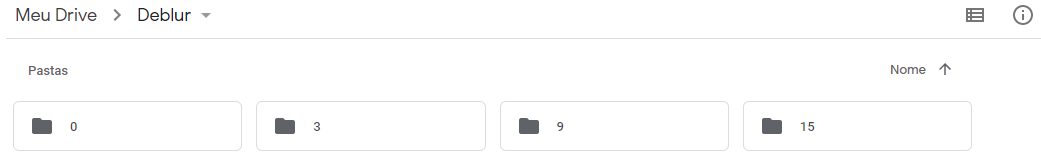

Inside the path of each blur level, create folders CAM01 (sharp images) and CAM02 (blurred images).

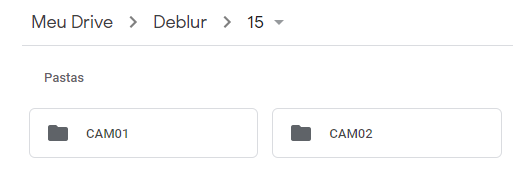

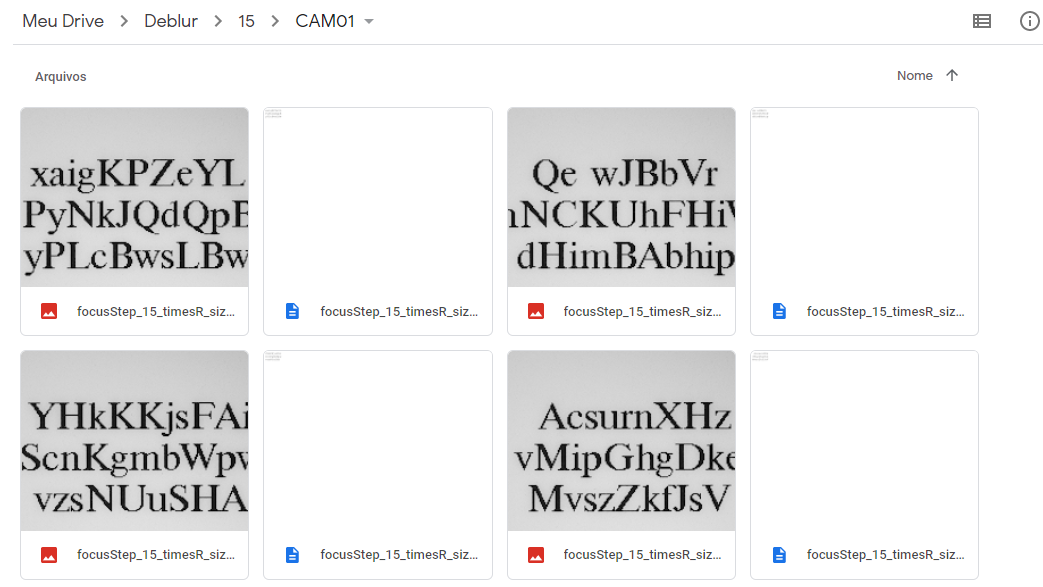

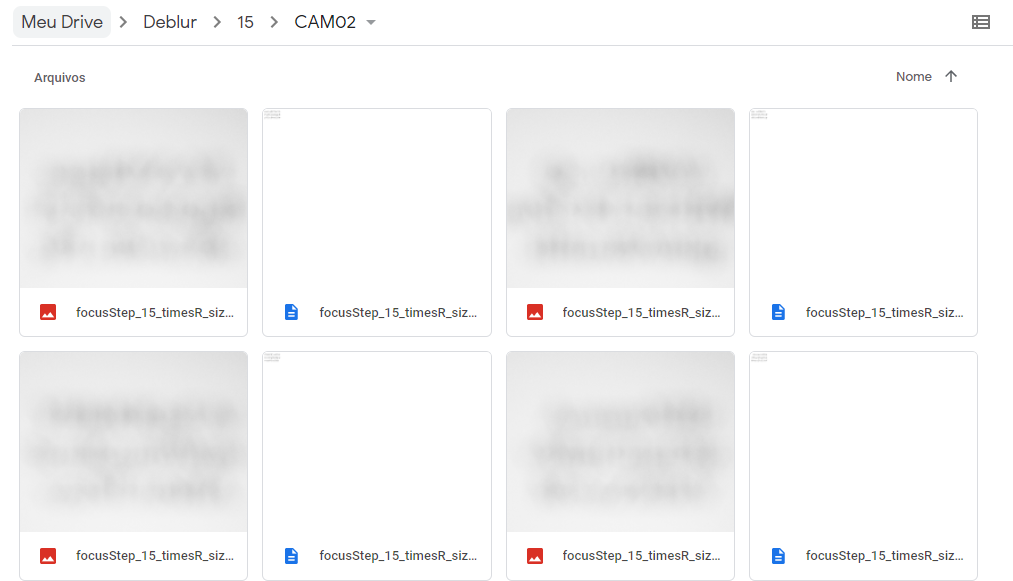

**Although the examples show multiple images and its .txt transcripts, there is only need to have one image .tif inside the each folder (CAM01 and CAM02) to this notebook to work.**

## Get image names

The sharp and blurred image should have the same names.

In [11]:
blur_lvl='5'

In [12]:
base_path=join('drive','MyDrive','Deblur')
sharp_path=join(base_path,blur_lvl,'CAM01')
blur_path=join(base_path,blur_lvl,'CAM02')

In [13]:
img_names=os.listdir(sharp_path)
r=re.compile(".*tif")
img_names=list(filter(r.match,img_names))
len(img_names)

1

# Create blur

**Nível 9:** 15

**Nível 15:** 26

In [14]:
kernel_type = 'circle'
radius = 8

blur = Blur(n_planes=1,kernel_type=kernel_type,sigma=radius).type(dtype)

# Deep prior

In [15]:
#  Image Parameters
width = 512 # Desired image width
enforse_div32 = 'EXTEND' # Force image to have dims multiple of 32 
img_ind=0 # Image you want to use to try to find the radius

# Input Parameters
input_depth = 32 
input_type = 'noise'
OPT_OVER = 'net'

# Optimization Parameters
LR = 0.01
tv_weight = 0
OPTIMIZER = 'adam'
pad = 'reflection'
num_iter= 800
reg_noise_std= 0.03
NET_TYPE = 'skip'
iter_lr=[200,400,600]
iter_mean=700

Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


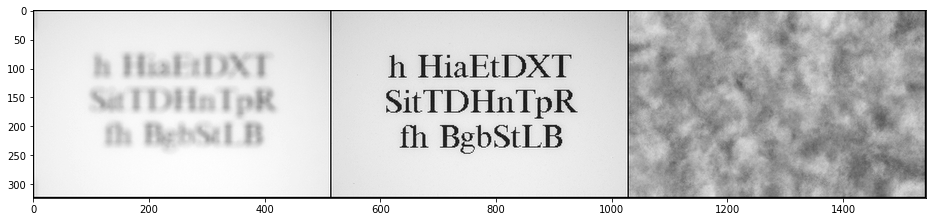

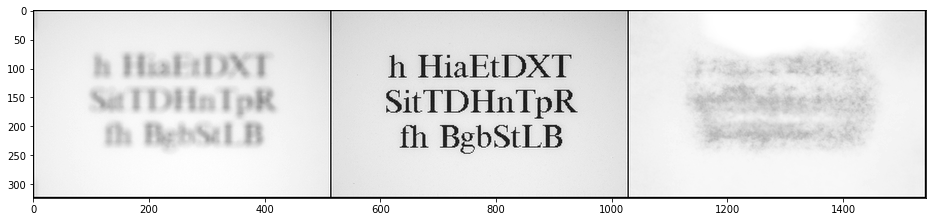

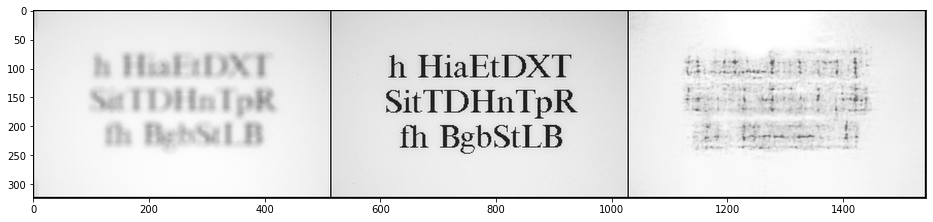

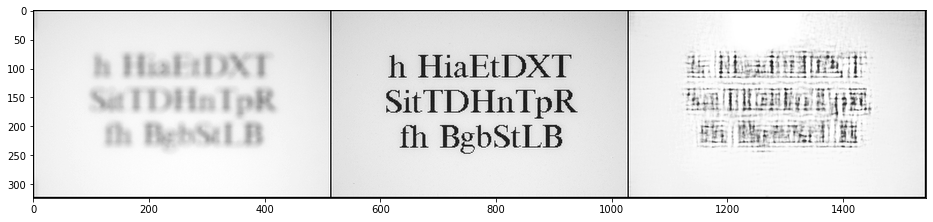

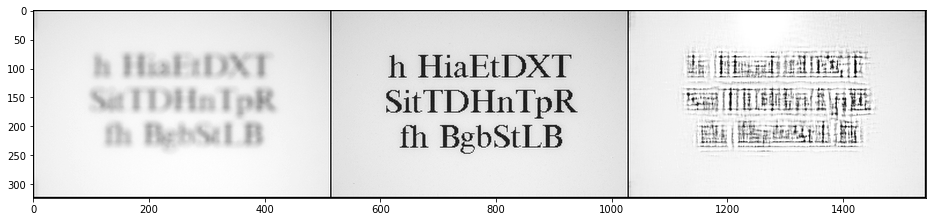

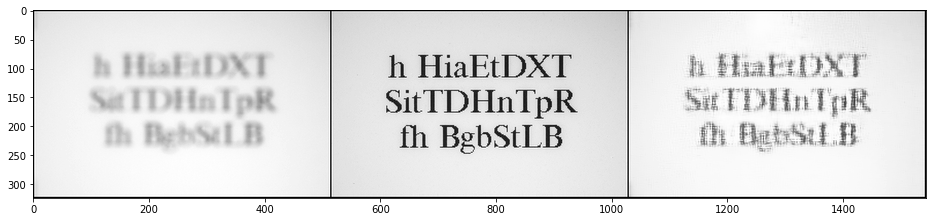

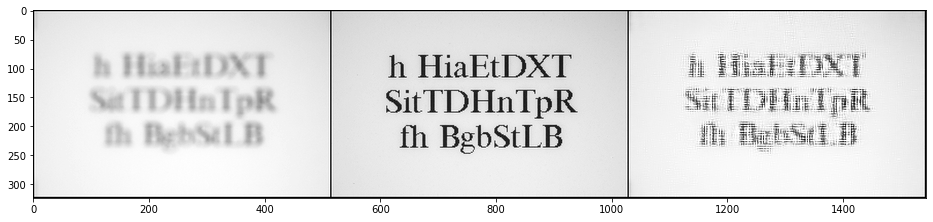

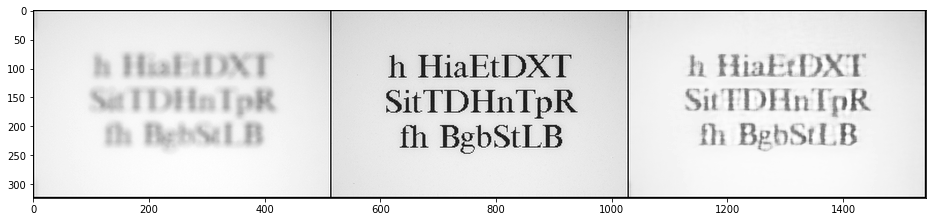

In [16]:
img_name=img_names[img_ind]
blur_name=join(blur_path,img_name)
sharp_name=join(sharp_path,img_name)

sharp_np=load_img(sharp_name,width=width,enforse_div32=enforse_div32)
img_np=load_img(blur_name,width=width,enforse_div32=enforse_div32)
img_torch=get_torch_imgs(img_np)
out_mean_deblur = np.zeros(img_np.shape)

deblur_input = get_noise(input_depth,input_type,(img_np.shape[1],img_np.shape[2])).type(dtype).detach()

deblur_net = get_net(input_depth, NET_TYPE, pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4,
              n_channels=1, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Deep prior to deblur
ind_lr=0

def deblur_closure():
  global i, deblur_input, out_mean_deblur, ind_lr
  
  if reg_noise_std > 0:
      deblur_input = net_input_saved + (noise.normal_() * reg_noise_std)
  else:
      deblur_input = net_input_saved
      
  out_sharp = deblur_net(deblur_input)
  out_blur = blur(out_sharp)

  if i in iter_lr:
    ind_lr+=1
  
  total_loss = 1 - ssim(out_blur, img_torch[ind_lr])
  
  if i>=iter_mean:
    out_sharp_np = torch_to_np(out_sharp)
    out_mean_deblur += out_sharp_np

  if tv_weight > 0:
      total_loss += tv_weight * tv_loss(out_sharp)
      
  total_loss.backward()
  
  if PLOT and i % 100 == 0:
      out_sharp_np = torch_to_np(out_sharp)
      plot_image_grid([img_np,sharp_np,out_sharp_np], factor=13, nrow=3)

  i += 1
  
  return total_loss

net_input_saved = deblur_input.detach().clone()
noise = deblur_input.detach().clone()

PLOT=True
i = 0
p = get_params('net', deblur_net,deblur_input,blur)
optimize(OPTIMIZER, p, deblur_closure, LR, num_iter)

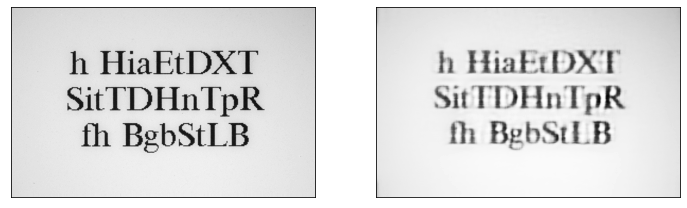

In [17]:
plt.figure(figsize=[12,6])

plt.subplot(1,2,1)
plt.imshow(sharp_np[0],cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(out_mean_deblur[0],cmap='gray')
plt.xticks([])
plt.yticks([])

plt.show();